<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Transformers/AG_news_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention mechanism and Transformers

Task: AG news classifiction

## Imports

In [2]:
!pip install pymorphy2 -q
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 944.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00


In [5]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import pymorphy2
import re
import random
import seaborn as sns
import string
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import datasets
from datasets import load_dataset

import nltk

from collections import Counter
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from transformers import get_scheduler
from transformers import BertTokenizer, BertModel
from typing import List

sns.set(palette='summer')

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Create tensorboard

In [ ]:
%load_ext tensorboard

log_dir = "./logs"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
writer = SummaryWriter(log_dir)
%tensorboard --logdir {log_dir}

## Set config

In [10]:
@dataclass
class CFG:
  bert_model = 'bert-base-cased'
  custom_name = 'model_v0'
  batch_size = 32
  lr = 1e-5
  attention_head = 1
  train_size = 20000
  test_size = 1000
  padding_idx = 0
  hdden_dim = 768
  scheduler_lambda = 0.96

In [11]:
STOP_WORDS = set(stopwords.words('english'))
PUNCT_TOKENIZER = nltk.WordPunctTokenizer()
MORPH = pymorphy2.MorphAnalyzer()

### Freeze seeds for reproducibility

In [12]:
def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [13]:
seed_everything()

## Data preparation

In [37]:
LABEL_NAMES = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Science/Technology"}

In [14]:
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [26]:
def preprocess_text(text):
    nums_filtered_text = re.sub(r'[0-9]+', '', text.lower())
    words = ' '.join([re.sub(r'[%s]' % re.escape(string.punctuation), ' ', word) for word in nums_filtered_text.split()])
    punct_filtered_text = ''.join([ch for ch in words if ch not in string.punctuation])
    tokens = PUNCT_TOKENIZER.tokenize(punct_filtered_text)
    filtr_stop_words_tokens = [MORPH.parse(token)[0].normal_form for token in tokens
                             if token not in STOP_WORDS]
    norm_tokens = [MORPH.parse(token)[0].normal_form for token in filtr_stop_words_tokens]

    return f"[CLS] {' '.join(norm_tokens)}"

In [27]:
X = dataset['train']['text']
y = dataset['train']['label']

X_test = dataset['test']['text']
y_test = dataset['test']['label']

In [87]:
sent_num = np.random.randint(len(X))
print(f"Label: {y[sent_num]} {LABEL_NAMES[y[sent_num]]}:\n\nOriginal {sent_num}:\n\t{X[sent_num]}\n\nPreprocessed:\n\t{preprocess_text(X[sent_num])}")

Label: 3 Science/Technology:

Original 41606:
	Intel Corp. Makes Marketing Push for Centrino Chip  SAN FRANCISCO (Reuters) - Intel Corp. &lt;A HREF="http://www.reuters.co.uk/financeQuoteLookup.jhtml?ticker=INTC.O qtype=sym infotype=info qcat=news"&gt;INTC.O&lt;/A&gt; on Monday  launched a global advertising campaign for its Centrino  notebook computer chips, aiming to boost sales of a brand that  has brought the world's largest chip maker more than \$3 billion  in revenue since its start last year.

Preprocessed:
	[CLS] intel corp makes marketing push centrino chip san francisco reuters intel corp lt href http www reuters co uk financequotelookup jhtml ticker intc qtype sym infotype info qcat news gt intc lt gt monday launched global advertising campaign centrino notebook computer chips aiming boost sales brand brought world largest chip maker billion revenue since start last year


In [152]:
sentence_samples_to_show_attention = [sent for sent in [X[1129], X[4534]]]
sentence_samples_to_show_attention

["Gartner revises PC market forecast, warns of downside The PC market won't grow as fast in 2004 as originally predicted by Gartner Inc. analysts, as concerns about the overall health of the U.S. economy weigh on the market, the market research company said Monday.",
 'Anno Captures Japan #39;s 6th Judo Gold; Inoue Fails to Win Medal Aug. 20 (Bloomberg) -- Noriko Anno, four-time world champion, won Japan #39;s sixth judo gold medal Thursday, defeating China #39;s Liu Xia in the women #39;s 78-kilogram class. ']

#### Visualize text length before and after preprocessing and tokenization

In [155]:
lengs = []
lengs = [len(PUNCT_TOKENIZER.tokenize(train_json['text'])) for train_json in tqdm(dataset['train'])]

  0%|          | 0/120000 [00:00<?, ?it/s]

In [123]:
def show_textlen_buckets(text_buckets, preprocess=True):
  total_texts = len(text_buckets)
  bucket_boundaries = [0, 30, 40, 45, 50, 70, np.inf]
  text_lengths = []

  for text in text_buckets:
    if preprocess:
      text = preprocess_text(text)
    text_length = len(text.split())
    text_lengths.append(text_length)

  plt.figure(figsize=(10, 6))
  plt.hist(text_lengths, bins=bucket_boundaries[:-1], alpha=0.5, edgecolor='black', linewidth=1.2)
  plt.xlabel('Text Length')
  plt.ylabel('Number of Texts')
  plt.title('Distribution of Text Lengths')
  plt.xticks(bucket_boundaries[:-1])
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  bin_counts, _ = np.histogram(text_lengths, bins=bucket_boundaries[:-1])
  for i, count in enumerate(bin_counts):
    plt.text(bucket_boundaries[i], count, f'{count/total_texts*100:.2f}%', va='bottom')
  plt.show()

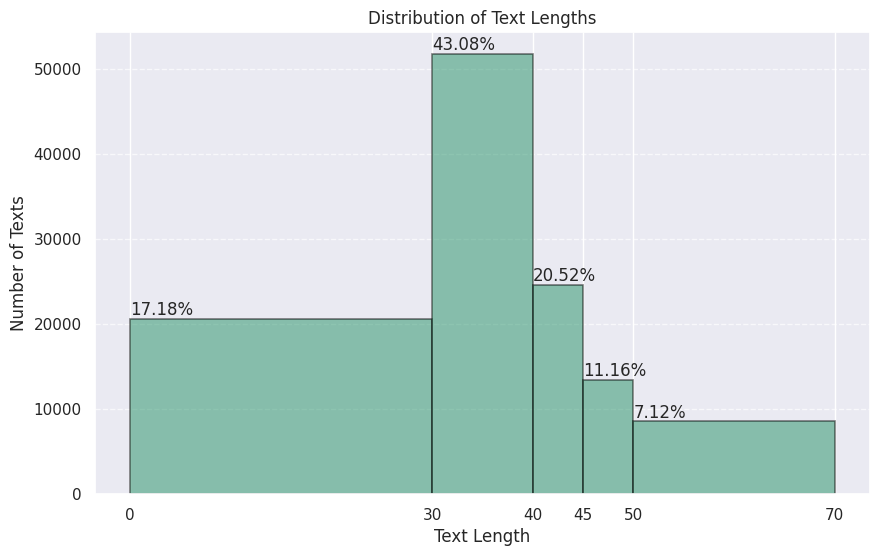

In [124]:
show_textlen_buckets(X, preprocess=False)

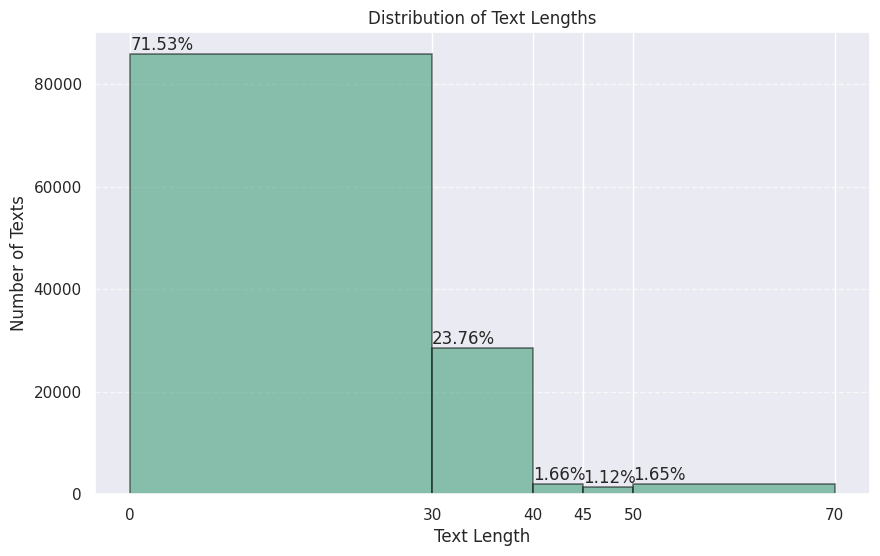

In [125]:
show_textlen_buckets(X)

#### Create Embeddings class

Here we remove all transfromer layers responsible for everything after the embeddings. This allows to obtain embeddings as a part of preprocessing. Kind of feature extractor - thats why we didn't set any pooling (just Identity output)

In [126]:
def prepare_bert_tokenizer_and_embedder(bert_model_name, device=device):
    tokenizer = BertTokenizer.from_pretrained(bert_model_name)
    bert_embedder = BertModel.from_pretrained(bert_model_name)
    bert_embedder.pooler = nn.Identity()
    del bert_embedder.encoder.layer[:]

    return tokenizer, bert_embedder.to(device)

In [127]:
tokenizer, embedder = prepare_bert_tokenizer_and_embedder(bert_model_name=CFG.bert_model)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

#### Add mask

To handle PADding acording to max length.
It takes the seq length tensor in a batch and generates a masked tensor based on length. valid(size less than curr seq length) and pad(size longer than curr seq length) positions. max_len allows to specify the len

In [132]:
def length_to_mask(length, max_len=None, dtype=None):
    """length: B.
    return B x max_len.
    If max_len is None, then max of length will be used.
    """
    assert len(length.shape) == 1, 'Length shape should be 1 dimensional.'
    max_len = max_len or length.max().item()
    mask = torch.arange(max_len, device=length.device,
                        dtype=length.dtype).expand(len(length), max_len) < length.unsqueeze(1)
    if dtype is not None:
        mask = torch.as_tensor(mask, dtype=dtype, device=length.device)
    return mask

#### Create custom data class

In [133]:
class MyDataset(Dataset):
  def __init__(self, hug_dataset, tokenizer, embedder=None, device=device):
    self.hug_dataset = hug_dataset # hugging dataset object
    self.tokenizer = tokenizer
    self.embedder = embedder
    self.device = device


  def __getitem__(self, idx):
    item_dict = self.hug_dataset[idx]
    text = item_dict['text']
    normalized_text = preprocess_text(text)
    target = item_dict['label']

    token_ids = self.text_to_tokens_ids(normalized_text)
    # pad tokens to length
    if self.embedder:
        return self.embedder(token_ids.unsqueeze(0)), target, len(token_ids)
    return token_ids, target


  def text_to_tokens_ids(self, text):
    tokens = self.tokenizer.tokenize(text)
    return torch.tensor(self.tokenizer.convert_tokens_to_ids(tokens)).to(device)


  def __len__(self):
    return len(self.hug_dataset)

Collate func for batch consistency

In [134]:
def collate_batch(batch):
  targets_list, embeddings_list, lengths_list = [], [], []

  for (_embed_output, _target, _text_len_in_tokens) in batch:
    _embed = _embed_output.last_hidden_state
    targets_list.append(_target)
    embeddings_list.append(_embed[0])
    lengths_list.append(_text_len_in_tokens)

  targets_tensor = torch.tensor(targets_list, dtype=torch.int64).to(device)
  embeddings_tensor = pad_sequence(embeddings_list, batch_first=True, padding_value=CFG.padding_idx).to(device)
  lengths_tensor = torch.tensor(lengths_list, dtype=torch.int64).to(device)

  return embeddings_tensor.detach(), targets_tensor.detach(), lengths_tensor

#### Create dataloaders

In [146]:
train_dataset = MyDataset(dataset['train'], tokenizer=tokenizer, embedder=embedder)
val_dataset = MyDataset(dataset['test'][:len(dataset['test'])//2], tokenizer=tokenizer, embedder=embedder)
test_dataset = MyDataset(dataset['test'][len(dataset['test'])//2:], tokenizer=tokenizer, embedder=embedder)


train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=CFG.batch_size, collate_fn=collate_batch, drop_last=True)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=CFG.batch_size, collate_fn=collate_batch, drop_last=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=CFG.batch_size, collate_fn=collate_batch, drop_last=True)

## Attention mechanism

**Attention** is a mechanism that calculates **how much focus** to put **on** different **parts of** the input **data**.

#### Self-attention

QVK come from the same sequence. Thus the model uses information from different positions of the **same sequence**.

#### Cross-attention

Q comes from previous layer's decoder output

KV - come from encoders output

Thus the decoder **focuses on** different parts of **input seq** based on **current state of the output**

#### Multihead-attention

Multiple sets of QKV - **focus on information from** different **representation subspaces at different positions**. Learns complex data better.

#### Q K V

Vectors representing different aspects of the input data:

**(Q) - Queries** -  **current item** in the sequence for which we're trying to compute attention. Like set of questions asked about the data.  **For a position** it seeks to **find relevant information** across all positions in another sequence (in self-attention - same seq)

**(K) - Keys** -  **paired with (V)** values and are used to **represent the memory** from which the query seeks information. Corresponds to one word or token in the dataset. When **Q** vector compared to **K** vector it hows relevance of each data piece in relation to **Q**.

**(V) - Values** - **actual information** from the dataset that the model is trying to retrieve or pay attention to.

After attention scores are computed we create a **weighted sum of value vector**. Thats the output that shows most relevant to the query information.

1. First we **find Q and K similarity** by finding the dot-product. If Q is similar to K that means Q should pay more attention to V.

2. **Normalize using softmax** (so weights sum up to 1) to **interpret weights as probs**.

3. Find weighted sum of V

Attention can be though of as *queries*, *keys* and *values* - where the query is used with the key to get an attention vector (usually the output of a *softmax* operation and has all values between 0 and 1 which sum to 1) which is then used to get a weighted sum of the values.


The Transformer uses *scaled dot-product attention*, where the query and key are combined by taking the dot product between them, then applying the softmax operation and scaling by $d_k$ before finally then multiplying by the value. $d_k$ is the *head dimension*.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$

This is similar to standard *dot product attention* but is scaled by $d_k$, which the paper states is used to stop the results of the dot products growing large, causing gradients to become too small.


#### Multi-head attention explanation

Instead of doing a single attention application the queries, keys and values have their `hid_dim` split into $h$ *heads* and the **scaled dot-product attention is calculated over all heads in parallel**. This means instead of paying attention to one concept per attention application, we **pay attention to $h$ number of concepts**. We then re-combine the heads into their `hid_dim` shape, thus each `hid_dim` is potentially paying attention to $h$ different concepts.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ is the linear layer applied at the end of the multi-head attention layer, `fc`. $W^Q, W^K, W^V$ are the linear layers `fc_q`, `fc_k` and `fc_v`.

#### Order of implementation

In the code below we're going to:

1. **Calculate** $QW^Q$, $KW^K$ and $VW^V$ with the linear layers, `fc_q`, `fc_k` and `fc_v`, to give us `Q`, `K` and `V`.
  
  **Why:** This step **projects the original queries (Q), keys (K), and values (V) into new spaces** that will be used for computing attention. It's akin to transforming the inputs into formats that are more suitable for extracting different types of information.
  
  **How:** Each layer transforms its respective input (Q, K, or V) by **multiplying it with a weight matrix** ($W^Q, W^K, W^V$).


2. **Split** the `hid_dim` of the query, key and value into `n_heads` using `.view` and correctly **permute them** so they can be multiplied together.

  **Why:** split into multiple 'heads' to allow the model to attend to different information simultaneously.
  
  **How:** The hid_dim (hidden dimension) of each Q, K, and V is split into n_heads segments.  Reshaping (or viewing) and permuting the tensors so that each head operates on a portion of the hidden dimension. The result is that **each head can focus on different parts of the input**.


3. **Calculate** the `energy` (the un-normalized attention) by multiplying `Q` and `K` together and scaling it by the square root of `head_dim`, which is calulated as `hid_dim // n_heads`.

  **Why:**  The 'energy' **measures the relevance or similarity between queries and keys**. It serves as the basis for determining how much each value should contribute to the output.
  
  **How:** **For each head, the dot product** is calculated between its **Q and K**, followed by **scaling the result** with the **square root of the head dimension** (head_dim). This scaling prevents the softmax operation from having very small gradients.


4. **Mask the energy** so we do not pay attention over any elements of the sequeuence we shouldn't pay to.

  **Why:**  To ensure that the model does not pay attention to certain positions (**padding** tokens **or future tokens** in seq2seq tasks).
  
  **How:** By **setting** the energies of positions that should not be attended to, **to a very large negative number** before **softmax**, which effectively **zeroes them out** after softmax.


5. Apply the **softmax** and **dropout**.

6. Apply the attention to the value heads, `V`, before combining the `n_heads` together.

  **Why:**  To compute the weighted sum of value vectors (weights are determined by the attention mechanism).
  
  **How:**  attention weights after (softmax and dropout) are used to compute a **weighted sum of the V, for each head** which **represents the output of the attention mechanism for each head**.


7. Multiply by $W^O$, represented by `fc_o`.


  **Why:** After computing the **attention outputs separately for each head**, they **are concatenated** back together and transformed once more to produce the **final output of the multi-head attention layer**.
  
  **How:** The outputs from all heads are concatenated and then multiplied by another weight matrix ($W^O$) through the final linear layer (fc_o). This step **combines information from all heads**.



#### matmul

Matrix multiplication of the `softmax` output, `attention`, with `V` (always have valid dimension sizes for matrix multiplication since the K and V are always the same in out implementation) is carried out using `torch.matmul` which, when both tensors are >2-dimensional, does a batched matrix multiplication over the last two dimensions of each tensor.

`torch.matmul` is used for efficiently computing the weighted sum of values across all batches and heads in parallel. This operation takes advantage of the multi-dimensional nature of the tensors to perform complex calculations in a highly optimized manner, crucial for the speed and scalability of Transformer models.

This will be a **[query len, key len] x [value len, head dim]** batched matrix multiplication over the batch size and each head which provides the **[batch size, n heads, query len, head dim]** result.

#### Dropout
**Dropout is applied directly to the attention**. This means that our attention vector will most probably not sum to 1 and we may pay full attention to a token but the attention over that token is set to 0 by dropout.

It introduces randomness in which parts of the sequence the model pays attention to. While this might seem counterintuitive (as it can lead to the model not paying attention to some parts at all due to dropout), it's a regularization technique to make the model more robust and prevent over-reliance on particular parts of the input.